<h1><center><font size='25'>Bitcoin price forecasting with Python</font></center></h1>

<center><b>Javier Escobar Ortiz</b></center>

<center><i>January, 2022</i></center>

Más sobre ciencia de datos: [**cienciadedatos.net**](https://cienciadedatos.net)

+ [Forecasting series temporales con Python y Scikit Learn](https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html)
+ [Predicción (forecasting) de la demanda eléctrica con Python](https://www.cienciadedatos.net/documentos/py29-forecasting-demanda-energia-electrica-python.html)
+ [skforecast](https://joaquinamatrodrigo.github.io/skforecast/latest/index.html)

Articulos usados

articulo sobre machine learning y graficas de btc: kde, añadir weighted moving avg como exog
https://medium.com/@rohansawant7978/forecasting-of-bitcoin-price-using-machine-learning-deep-learning-techniques-93bf662f46ab

datos btc
https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory/version/3?select=coin_Bitcoin.csv

coinmarket btc halving
https://coinmarketcap.com/es/halving/bitcoin/

## Introducción

## Caso de uso

## Librerias

In [27]:
import pandas as pd
import numpy as np
import datetime

import plotly.graph_objects as go
import seaborn as sns

## Datos

In [2]:
# Descarga de datos
# ==============================================================================
pd.set_option('display.max_columns', None)

url = r'https://raw.githubusercontent.com/JavierEscobarOrtiz/Workingon/main/00%20-%20Cienciadedatos/datasets/Bitcoin_042013_072021.csv'
data_raw = pd.read_csv(url)
display(data_raw)

pd.reset_option('display.max_columns')

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


In [14]:
data = data_raw.copy()
data['date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data.drop(['SNo', 'Name', 'Symbol', 'Date', 'Volume', 'Marketcap'], axis=1, inplace=True)
data.rename({'High': 'high', 'Low': 'low', 'Open': 'open', 'Close': 'close'}, axis=1, inplace=True)
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()

One of the first analyses to perform when working with time series is to verify whether the series is complete.

In [15]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()

True

In [16]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


## Halving BTC

In [17]:
btc_halving = {'halving'              : [0, 1 , 2, 3, 4],
               'date'                 : ['2009-01-03', '2012-11-28', '2016-07-09', '2020-05-11', np.nan],
               'reward'               : [50, 25, 12.5, 6.25, 3.125],
               'halving_block_number' : [0, 210000, 420000 ,630000, 840000]
              }

In [18]:
# calculo fecha halving

# 14/01/2022 
bloques_restantes = 121400
bloques_dia = 144

dias = bloques_restantes / bloques_dia

next_halving = pd.to_datetime('2022-01-14', format='%Y-%m-%d') + datetime.timedelta(days=dias)
next_halving = next_halving.replace(microsecond=0, second=0, minute=0, hour=0)

btc_halving['date'][-1] = next_halving

print(next_halving)

2024-05-06 00:00:00


In [19]:
data['reward'] = np.nan
data['countdown_halving'] = np.nan
data['day'] = pd.to_datetime(data.index.date, format='%Y-%m-%d')

for i in range(len(btc_halving['date'])-1):
    
    # Select start date and end date of halving
    start_date = pd.to_datetime(btc_halving['date'][i], format='%Y-%m-%d %H:%M:%S')
    end_date = pd.to_datetime(btc_halving['date'][i+1], format='%Y-%m-%d %H:%M:%S')
    mask = (data.index > start_date) & (data.index <= end_date)
    
    # Fill reward column
    data.loc[mask, 'reward'] = btc_halving['reward'][i]
    
    # Fill countdown until next halving column
    delta = end_date - start_date
    days = [day+1 for day in range(delta.days)][::-1]
    
    i = pd.date_range(start_date, periods=delta.days, freq='D')
    df_aux = pd.DataFrame({'countdown_aux':days}, index=i)
    
    data = data.merge(df_aux, how='left', left_on='day', right_index=True)
    data['countdown_halving'].fillna(data['countdown_aux'], inplace=True)
    data.drop(['countdown_aux'], axis=1, inplace=True)
    
data.drop(['day'], axis=1, inplace=True)
data

,high,low,open,close,reward,countdown_halving
date,,,,,,
2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,25.00,1167.0
2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,25.00,1166.0
2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,25.00,1165.0
2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,25.00,1164.0
2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,25.00,1163.0
...,...,...,...,...,...,...
2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,6.25,1039.0
2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,6.25,1038.0
2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,6.25,1037.0


In [20]:
print('Second Halving:', btc_halving['date'][2])
display(data.loc['2016-07-08 23:59:59':'2016-07-09 23:59:59'])
print('')
print('Third Halving:', btc_halving['date'][3])
display(data.loc['2020-05-10 23:59:59':'2020-05-11 23:59:59'])
print('')
print('To fourth Halving:', btc_halving['date'][4])
data.tail(2)

Second Halving: 2016-07-09


,high,low,open,close,reward,countdown_halving
date,,,,,,
2016-07-08 23:59:59,666.706970,636.466980,640.687988,666.523010,25.0,1.0
2016-07-09 23:59:59,666.383972,633.398987,666.383972,650.960022,12.5,1402.0



Third Halving: 2020-05-11


,high,low,open,close,reward,countdown_halving
date,,,,,,
2020-05-10 23:59:59,9595.580629,8395.107451,9591.169231,8756.431142,12.50,1.0
2020-05-11 23:59:59,9033.471176,8374.322975,8755.535639,8601.796202,6.25,1456.0



To fourth Halving: 2024-05-06 00:00:00


,high,low,open,close,reward,countdown_halving
date,,,,,,
2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,6.25,1036.0
2021-07-06 23:59:59,35038.536363,33599.916169,33723.509655,34235.193451,6.25,1035.0


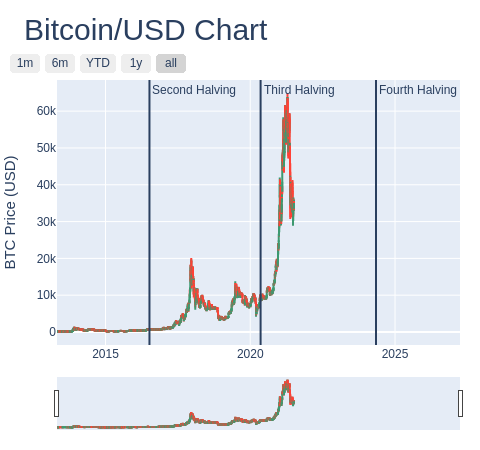

In [101]:
candlestick = go.Candlestick(
                            x = data.index,
                            open = data.open,
                            close = data.close,
                            low = data.low,
                            high = data.high,
                            )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 900,
    height      = 450,
    title       = dict(text='Bitcoin/USD Chart', font=dict(size=30)),
    yaxis_title = dict(text='BTC Price (USD)', font=dict(size=15)),
    margin      = dict(l=10, r=20, t=80, b=20),
    shapes      = [dict(x0=btc_halving['date'][2], x1=btc_halving['date'][2], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][3], x1=btc_halving['date'][3], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2),
                   dict(x0=btc_halving['date'][4], x1=btc_halving['date'][4], 
                        y0=0, y1=1, xref='x', yref='paper', line_width=2)
                  ],
    annotations = [dict(x=btc_halving['date'][2], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Second Halving'),
                   dict(x=btc_halving['date'][3], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Third Halving'),
                   dict(x=btc_halving['date'][4], y=1, xref='x', yref='paper',
                      showarrow=False, xanchor='left', text='Fourth Halving')
                  ]
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label='1m', step='month', stepmode='backward'),
            dict(count=6, label='6m', step='month', stepmode='backward'),
            dict(count=1, label='YTD', step='year', stepmode='todate'),
            dict(count=1, label='1y', step='year', stepmode='backward'),
            dict(step='all')
        ])
    )
)

fig.show()

## Exploración Gráfica

**Cambio de precio por año**

In [156]:
# Se localizan los datos correspondientes para cada año
years = list(data.index.year.unique())
df = pd.DataFrame()

for year in years:
    
    year_open  = data[data.index.year == year].loc[:, 'open'][0]
    year_close = data[data.index.year == year].loc[:, 'close'][-1]
    year_low  = data[data.index.year == year].loc[:, 'low'].min()
    year_high = data[data.index.year == year].loc[:, 'high'].max()
    
    df[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_plot = df.T
df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1, inplace=True)
# Se calcula el % de cambio entre el open y el close del año
df_plot['pct_change'] = df.pct_change().iloc[-3,:]*100
df_plot

,open,close,low,high,pct_change
2013,134.444000,754.010010,65.526001,1156.140015,460.835745
2014,754.969971,320.192993,289.295990,1017.119995,-57.588645
2015,320.434998,430.566986,171.509995,495.562012,34.369526
2016,430.721008,963.742981,354.914001,979.396973,123.751097
2017,963.658020,14156.400391,755.755981,20089.000000,1369.027404
2018,14112.200195,3742.700335,3191.303562,17712.400391,-73.478974
2019,3746.713387,7193.598978,3391.023752,13796.489081,91.997579
2020,7194.891971,29001.719822,4106.980750,29244.876688,303.087634
2021,28994.008916,34235.193451,28722.755271,64863.098908,18.076785


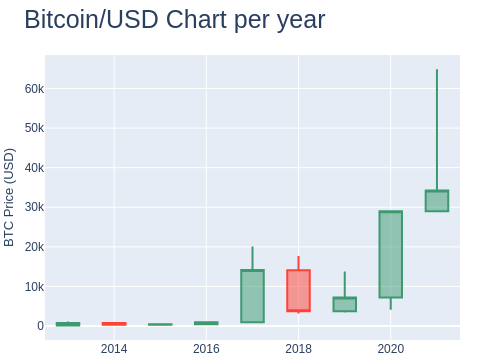

In [154]:
candlestick = go.Candlestick(
                            x = pd.to_datetime(df_plot.index, format='%Y'),
                            open = df_plot.open,
                            close = df_plot.close,
                            low = df_plot.low,
                            high = df_plot.high
                            )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='Bitcoin/USD Chart per year', font=dict(size=25)),
    yaxis_title = dict(text='BTC Price (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    )

fig.show()

In [ ]:
# Split dataframe

train_window = 500
test_window = 100
train_splits = []
test_splits = []
for i in tqdm(range(train_window, len(final_df),test_window)):
    train_split = final_df[i-train_window:i]
    test_split = final_df[i:i+test_window]
    train_splits.append(train_split)
    test_splits.append(test_split)